# [Regression with a Crab Age Dataset](https://www.kaggle.com/competitions/playground-series-s3e16/overview)

## Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

## Dataset and Pre-Processing

In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e16/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e16/test.csv")

train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [6]:
train_df.drop(columns=["id"], inplace=True)
# test_df.drop(columns=["id"], inplace=True)
train_df['Sex'] = train_df['Sex'].map({'M':0,'F':1,'I':2})
test_df['Sex'] = test_df['Sex'].map({'M':0,'F':1,'I':2})

In [7]:
plt.rcParams['figure.figsize'] = (20, 15)

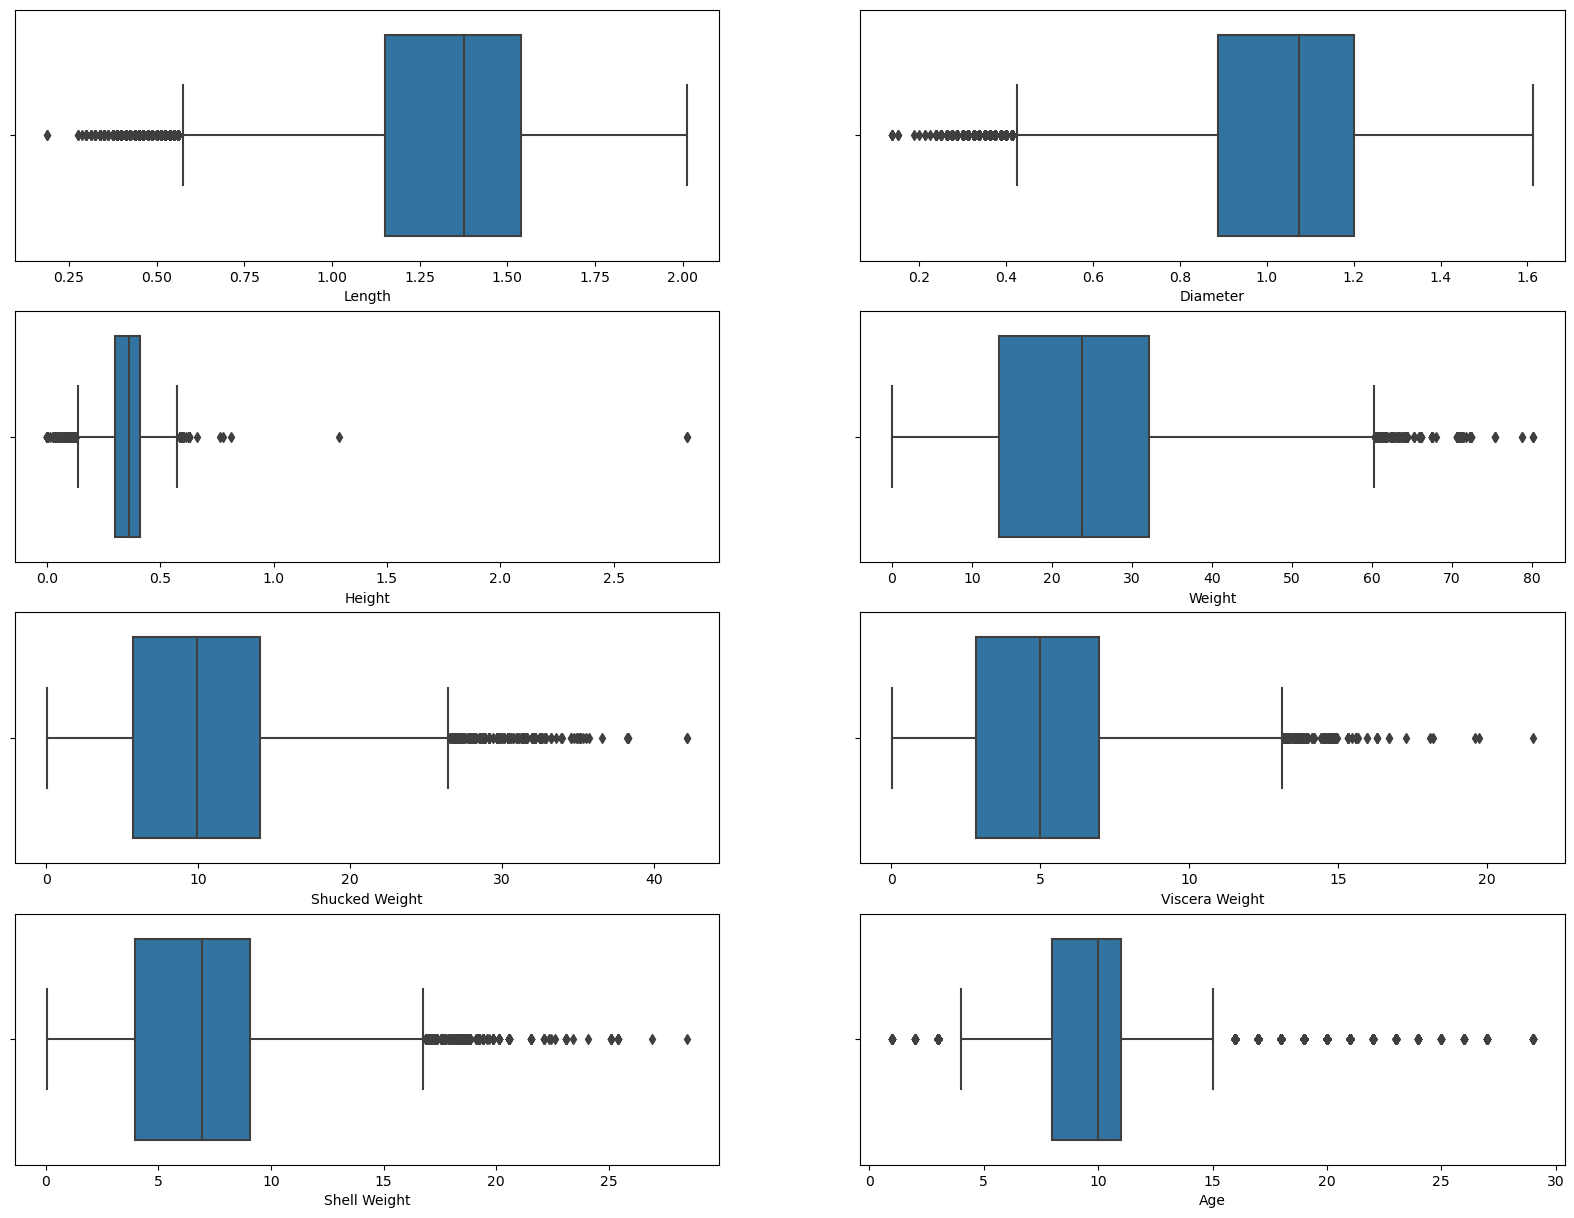

In [8]:
for i, col in enumerate(train_df.columns[1:]):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=train_df[col])
    plt.xlabel(col)

plt.show()

In [9]:
train_df = train_df[train_df["Length"] > 0.35]
train_df = train_df[train_df["Diameter"] > 0.3]
train_df = train_df[train_df["Height"] < 0.7]
train_df = train_df[train_df["Height"] > 0.1]
train_df = train_df[train_df["Weight"] < 70]
train_df = train_df[train_df["Shucked Weight"] < 30]
train_df = train_df[train_df["Viscera Weight"] < 15]
train_df = train_df[train_df["Shell Weight"] < 20]
train_df = train_df[train_df["Age"] < 20]

In [10]:
X, y = train_df.drop(columns=["Age"]), train_df["Age"]

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

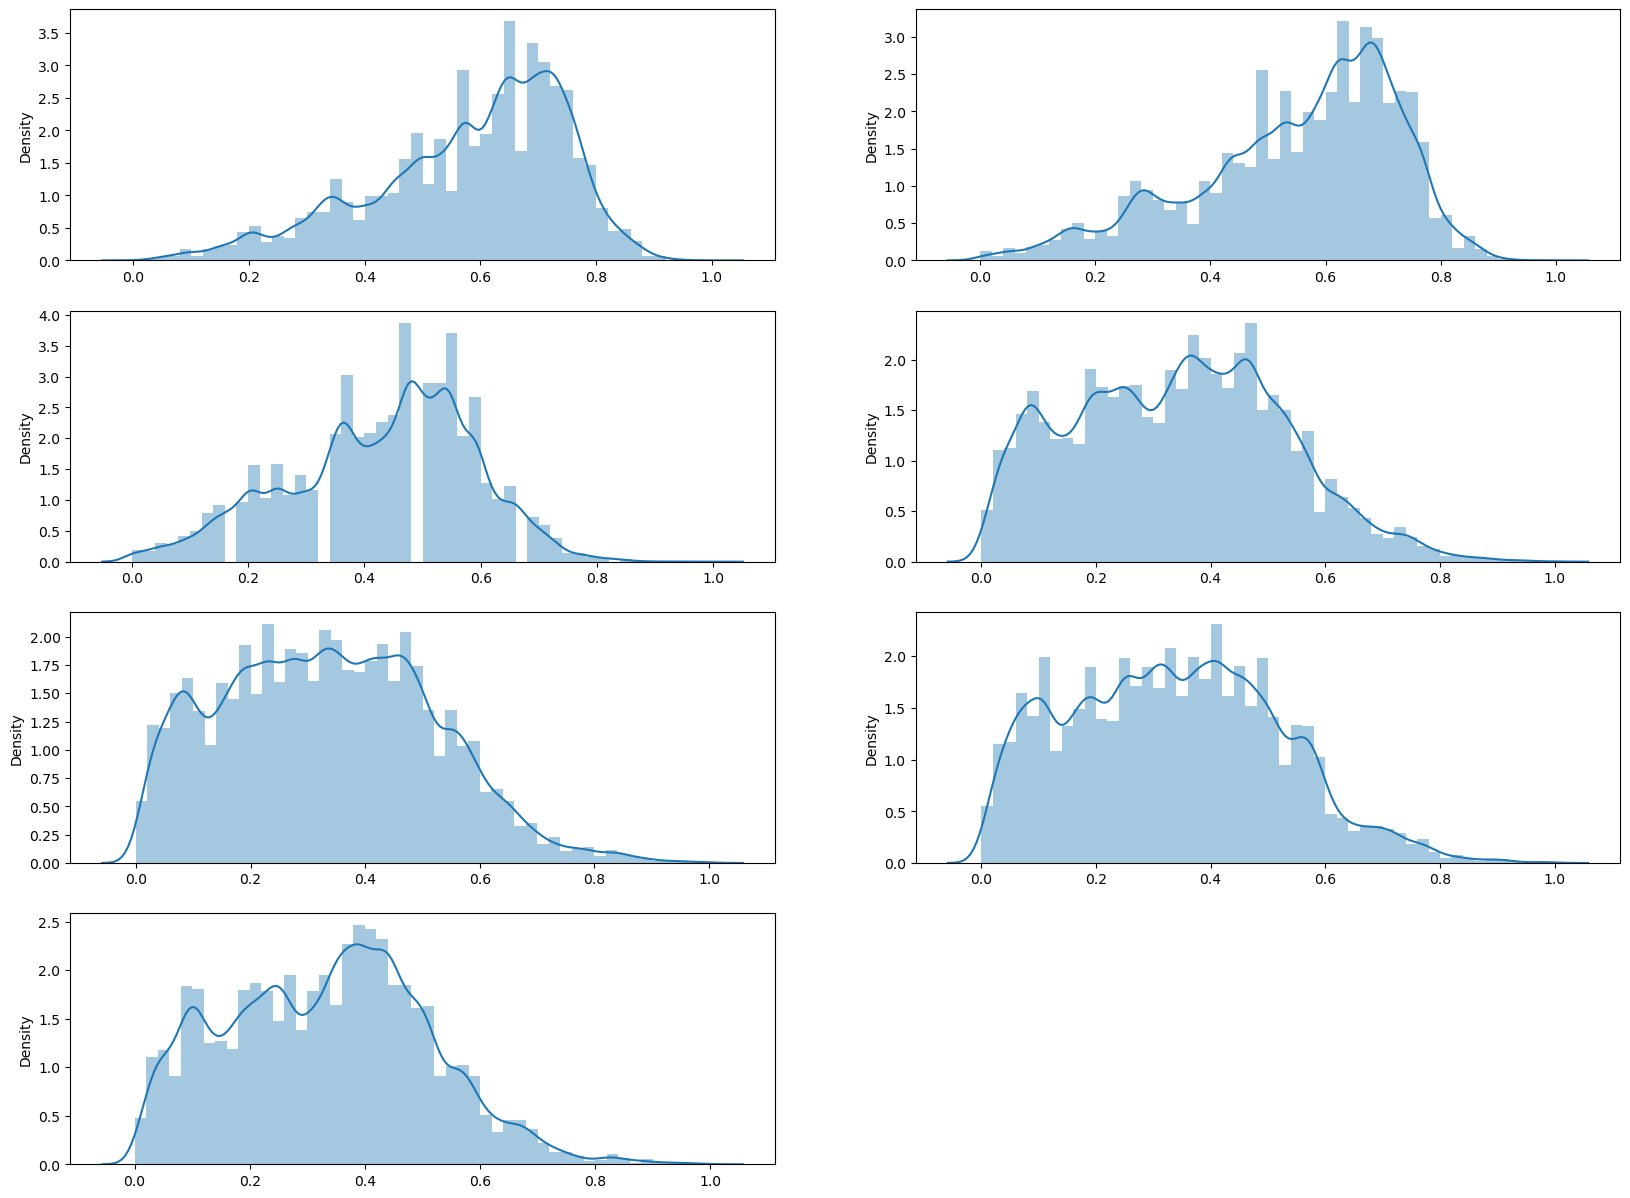

In [14]:
for i in range(1, X_scaled.shape[1]):
    plt.subplot(4, 2, i)
    sns.distplot(X_scaled[:, i])

plt.show()

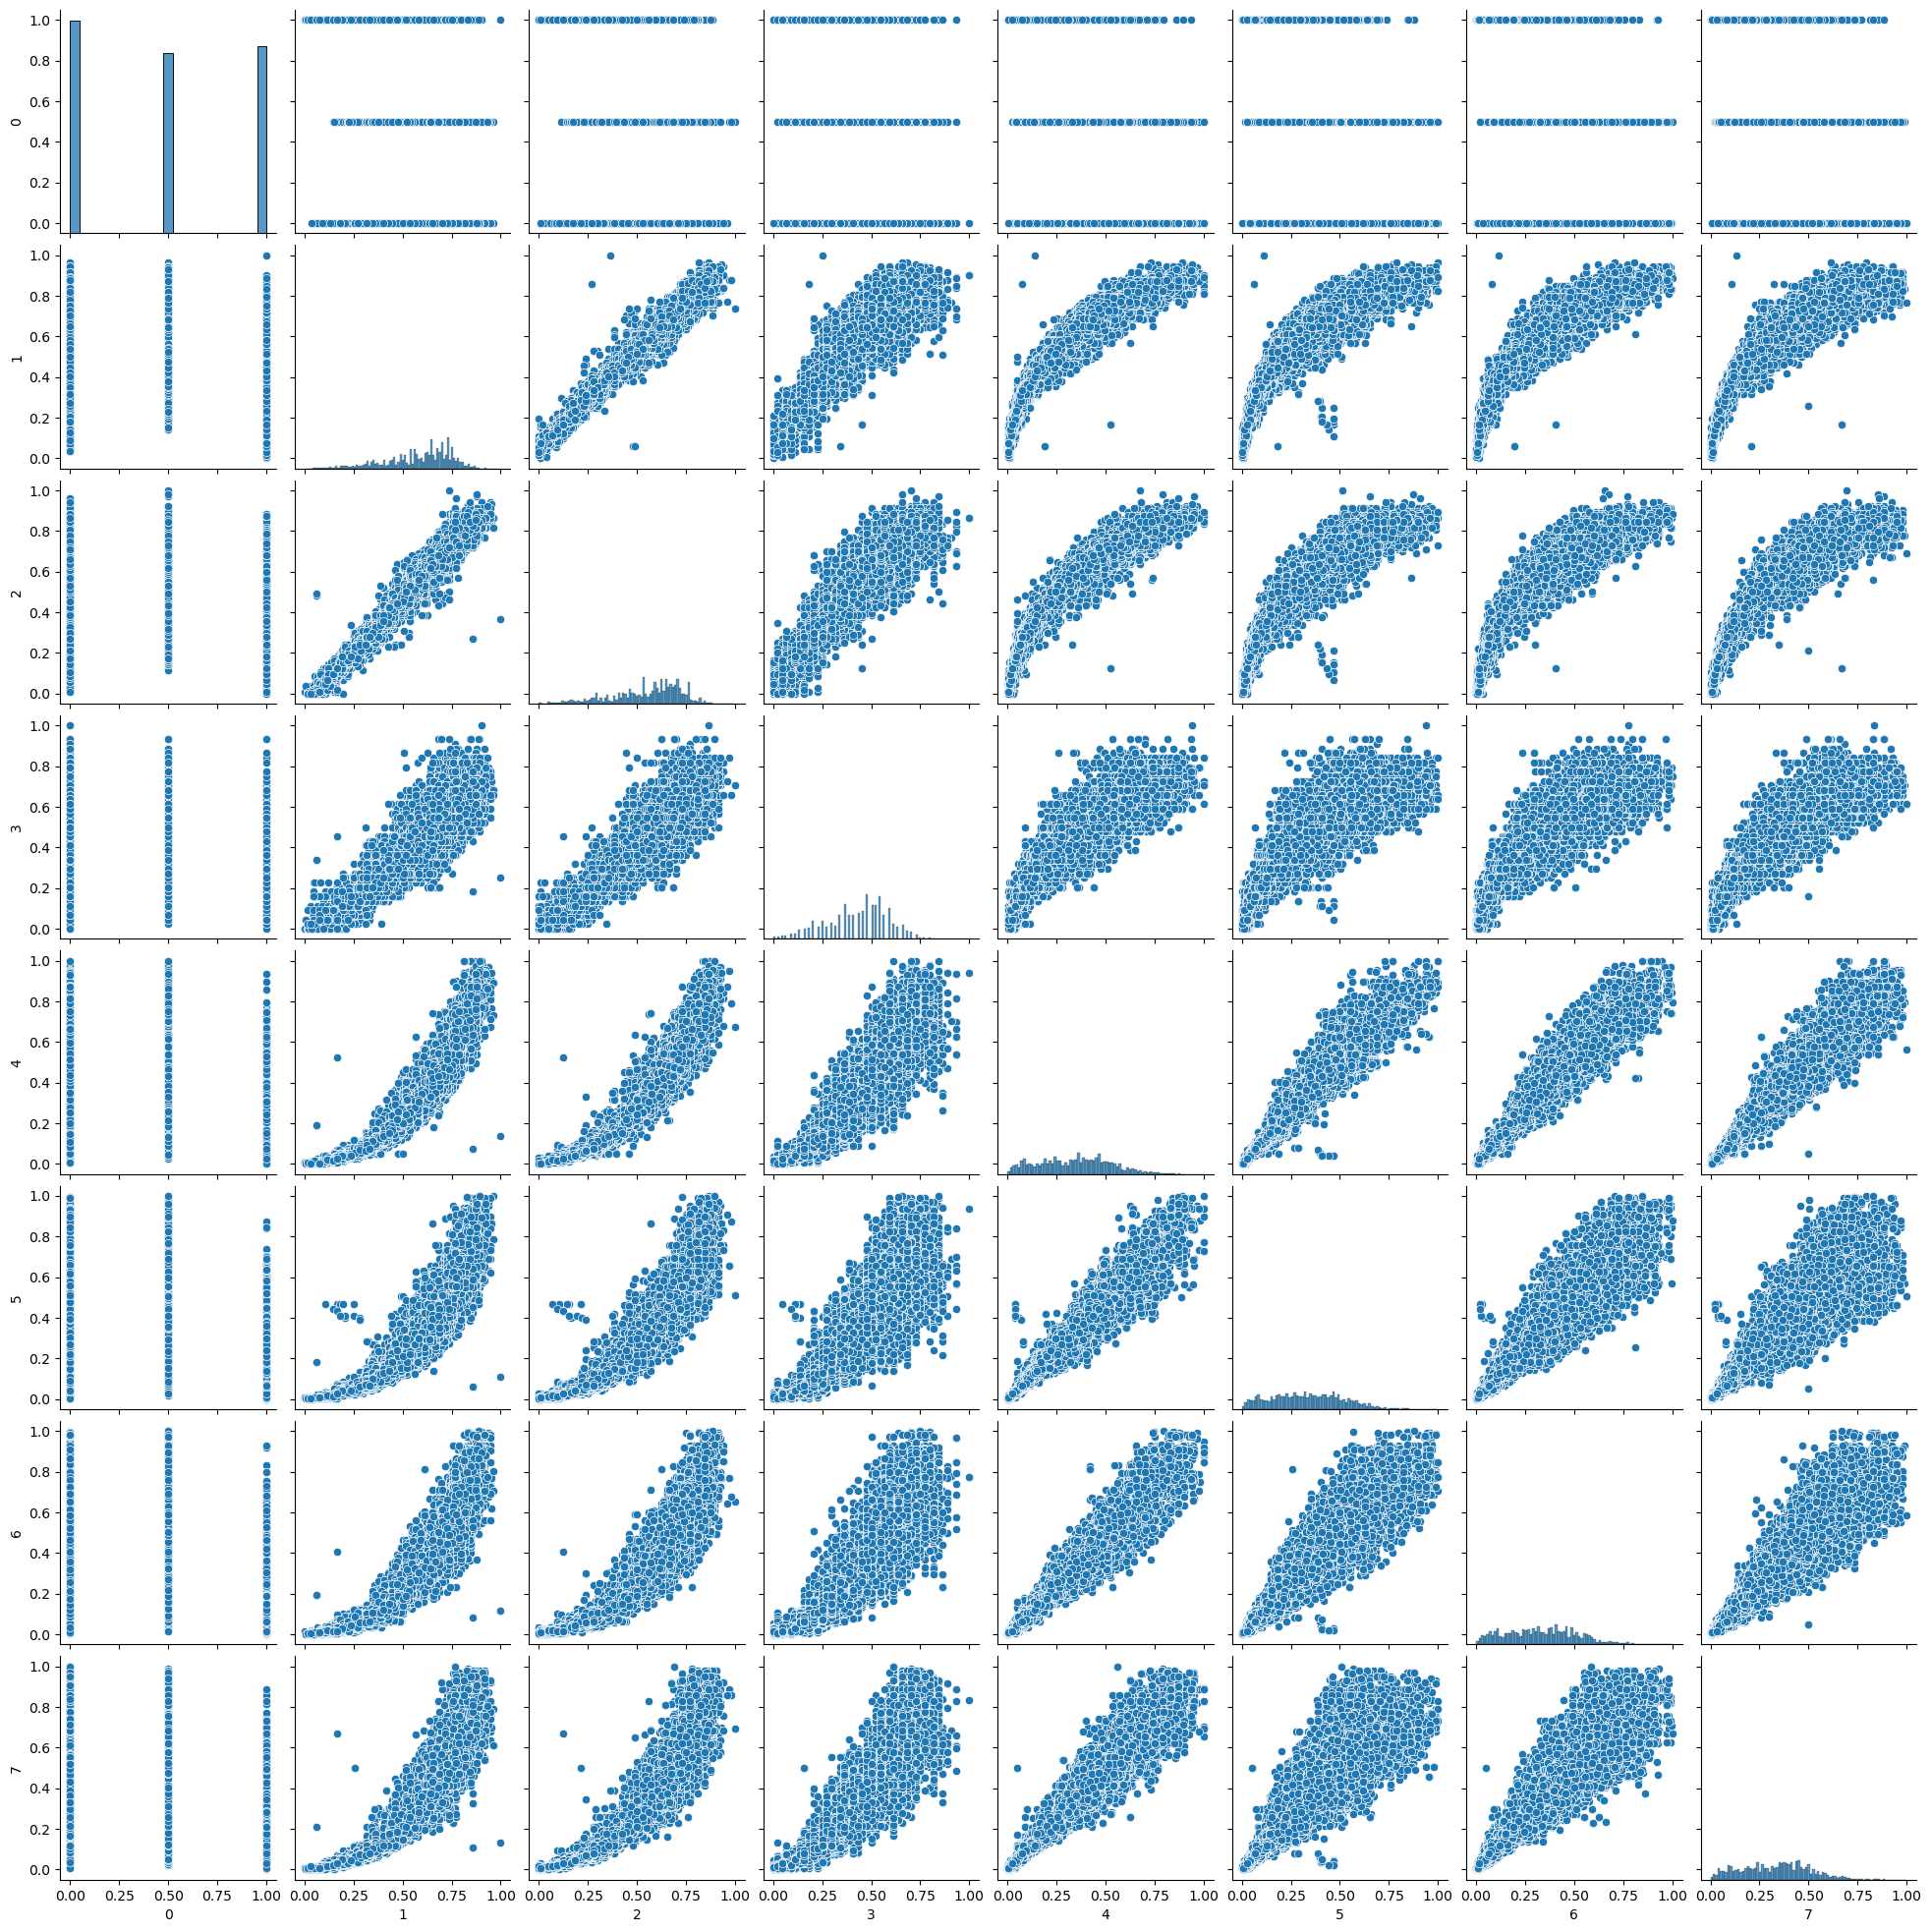

In [25]:
sns.pairplot(pd.DataFrame(X_scaled), diag_kind="hist")
plt.show()

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2)

## XGB Regressor

In [16]:
xgb = XGBRegressor(n_estimators=1000,learning_rate=0.01)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
xgb_pred = xgb.predict(X_val)
print('Mean Absolute Error : ',round(mean_absolute_error(xgb_pred,y_val), 5))

Mean Absolute Error :  1.31838


In [21]:
test_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,2,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,2,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,1,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,1,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,2,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [22]:
X_test_scaled = scaler.transform(test_df.iloc[:,1:])
y_test_pred = xgb.predict(X_test_scaled)

In [52]:
submission_df = pd.DataFrame({'id': test_df['id'], 'Age': y_test_pred})
submission_df.to_csv('/kaggle/working/submission_RwCAD1.csv',index=False)

In [51]:
submission_df.head()

,id,Age
0,74051,7.611353
1,74052,7.807754
2,74053,10.677252
3,74054,9.536383
4,74055,7.515895


## Pytorch Custom Model

In [41]:
def getDataLoaders(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train.values)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val.values)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    
    return train_loader, val_loader

In [42]:
class CrabAgeRegressor(nn.Module):
    
    def __init__(self):
        super(CrabAgeRegressor, self).__init__()
        
        self.dense1 = nn.Linear(8, 64)
        self.relu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(64, 32)
        self.relu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.dense3 = nn.Linear(32, 1)
        self.relu3 = nn.PReLU()
        
    def forward(self, x):
        dense_out1 = self.dropout1(self.relu1(self.dense1(x)))
        dense_out2 = self.dropout2(self.relu2(self.dense2(dense_out1)))
        out = self.relu3(self.dense3(dense_out2))
        return out

In [45]:
model = CrabAgeRegressor()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
n_epochs = 100

In [46]:
for epoch in range(n_epochs):
    train_loader, val_loader = getDataLoaders(X_scaled, y)
    
    training_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1,1))
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    
    epoch_loss = training_loss / len(train_loader)
    
    val_loss = 0.0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1,1))
        val_loss += loss.item()
        
    val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {round(epoch_loss, 5)} - Validation Loss: {round(val_loss, 5)}")

Epoch 1/100 - Training Loss: 1.99709 - Validation Loss: 1.70143
Epoch 2/100 - Training Loss: 1.61091 - Validation Loss: 1.58651
Epoch 3/100 - Training Loss: 1.56897 - Validation Loss: 1.5464
Epoch 4/100 - Training Loss: 1.53577 - Validation Loss: 1.51588
Epoch 5/100 - Training Loss: 1.50436 - Validation Loss: 1.51949
Epoch 6/100 - Training Loss: 1.48982 - Validation Loss: 1.49193
Epoch 7/100 - Training Loss: 1.4606 - Validation Loss: 1.46387
Epoch 8/100 - Training Loss: 1.45151 - Validation Loss: 1.43174
Epoch 9/100 - Training Loss: 1.43143 - Validation Loss: 1.43934
Epoch 10/100 - Training Loss: 1.42462 - Validation Loss: 1.41322
Epoch 11/100 - Training Loss: 1.41483 - Validation Loss: 1.4253
Epoch 12/100 - Training Loss: 1.40629 - Validation Loss: 1.40838
Epoch 13/100 - Training Loss: 1.40448 - Validation Loss: 1.40927
Epoch 14/100 - Training Loss: 1.39469 - Validation Loss: 1.39666
Epoch 15/100 - Training Loss: 1.39708 - Validation Loss: 1.36184
Epoch 16/100 - Training Loss: 1.38666

In [47]:
model.eval()
with torch.no_grad():
    X_test = torch.Tensor(X_test_scaled)
    y_test_pred = model(X_test)

In [48]:
submission_df = pd.DataFrame({'id': test_df['id'], 'Age': y_test_pred[:, 0]})
submission_df.to_csv('/kaggle/working/submission_RwCAD2.csv',index=False)